# Stock Char Pattern Recognition Using Deep learning

## 1️⃣ Import libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

# 🚨 เพิ่ม Conv1D, MaxPooling1D, และ Flatten สำหรับ CNN-LSTM Hybrid Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten 
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# 🚨 ต้องเพิ่ม import นี้สำหรับการตรวจจับ H&S
from scipy.signal import find_peaks 


## 2️⃣ ดึงข้อมูลจาก Cassandra

In [71]:
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df


# 3️⃣ ตรวจจับ Head & Shoulders (H&S/IH&S)

In [72]:
def detect_head_shoulders(df, distance=5, tolerance=0.05):
    """ตรวจจับรูปแบบ H&S และ IH&S พร้อมหา Neckline และ Breakout"""
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []
    
    # H&S (ไหล่-หัว-ไหล่) - สัญญาณขาย (Bearish)
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        if r >= len(prices) - 1: continue 
            
        left, head, right = prices[l], prices[h], prices[r]
        
        if head > left and head > right and abs(left - right) / head < tolerance:
            trough1_idx = np.argmin(prices[l:h]) + l
            trough2_idx = np.argmin(prices[h:r]) + h

            neck_end_price = prices[trough2_idx]
            neck_start_price = prices[trough1_idx]
            neck_slope = (neck_end_price - neck_start_price) / (trough2_idx - trough1_idx)
            
            post_pattern_prices = prices[trough2_idx + 1:]
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices < neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = trough2_idx + 1 + breakout_points[0]
                
                # การคำนวณ Target ที่ถูกต้องตามหลัก H&S: ใช้ความสูงของ Head จาก Neckline ที่จุด Head
                # คำนวณราคา Neckline ที่ตรงกับจุด Head (h)
                neckline_at_head = neck_start_price + neck_slope * (h - trough1_idx)
                target_height = head - neckline_at_head 
                target_price = prices[break_idx] - target_height
                
                patterns.append({
                    "type": "H&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": trough1_idx, "t2": trough2_idx, 
                    "break_idx": break_idx,
                    "target_price": target_price 
                })

    # IH&S (ไหล่-หัว-ไหล่กลับหัว) - สัญญาณซื้อ (Bullish)
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        if r >= len(prices) - 1: continue
            
        left, head, right = prices[l], prices[h], prices[r]
        
        if head < left and head < right and abs(left - right) / abs(head) < tolerance:
            
            peak1_idx = np.argmax(prices[l:h]) + l
            peak2_idx = np.argmax(prices[h:r]) + h

            neck_end_price = prices[peak2_idx]
            neck_start_price = prices[peak1_idx]
            neck_slope = (neck_end_price - neck_start_price) / (peak2_idx - peak1_idx)
            
            post_pattern_prices = prices[peak2_idx + 1:]
            
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices > neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = peak2_idx + 1 + breakout_points[0]
                
                # การคำนวณ Target ที่ถูกต้องตามหลัก IH&S
                neckline_at_head = neck_start_price + neck_slope * (h - peak1_idx)
                target_height = neckline_at_head - head
                target_price = prices[break_idx] + target_height
                
                patterns.append({
                    "type": "IH&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": peak1_idx, "t2": peak2_idx, 
                    "break_idx": break_idx,
                    "target_price": target_price 
                })
    return patterns


# 4️⃣ สร้าง Label ทิศทาง (0=ลง/คงที่, 1=ขึ้น)

In [73]:
def create_direction_labels(df_close: pd.Series, future_days: int = 1):
    """
    สร้าง Label ทิศทางราคา: 1 ถ้า Close Price ใน 'future_days' วันข้างหน้าขึ้น, 0 ถ้าลงหรือคงที่
    """
    future_price = df_close.shift(-future_days)
    labels = (future_price > df_close).astype(int)
    
    return labels[:-future_days] 


# 5️⃣ เตรียมข้อมูลสำหรับ Deep Learning (สำหรับ 2 Class)

In [74]:
def preprocess_and_create_sequences(df, labels, seq_len=30):
    features_cols = ['open', 'high', 'low', 'close', 'volume']
    
    df_aligned = df.iloc[:len(labels)] 
    # 🌟 แก้ไข: ใช้ .ffill() แทน fillna(method='ffill') 
    data = df_aligned[features_cols].ffill().values 
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_len):
        X.append(data_scaled[i:i+seq_len])
        y.append(labels[i+seq_len]) 
        
    X = np.array(X)
    y = np.array(y)
    
    if len(X) == 0:
        raise ValueError("Sequence length is too long for the given data. Check seq_len and data length.")
        
    return X, y, scaler


## 6️⃣  CNN-LSTM  

In [75]:
def build_cnn_lstm_model(seq_len, n_features, n_classes=2):

    model = Sequential([
        # 1. CNN Section: ดึง Local Features
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, n_features)),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # 2. LSTM Section: เรียนรู้ Temporal Dependencies
        LSTM(64, activation='tanh'),
        Dropout(0.2),
        
        # 3. Dense Section: Classification
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax') # n_classes=2
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# 7️⃣ Pipeline train model

In [76]:
def train_pipeline(symbol='AOT', cass_limit=1200, seq_len=30, epochs=10, future_days=1):
    """ขั้นตอนการดึงข้อมูล เตรียมข้อมูล และฝึกโมเดล"""
    print(f"1. ดึงข้อมูล {symbol} (Limit: {cass_limit} วัน)...")
    df = get_candlestick_data(symbol, limit=cass_limit)
    
    print(f"2. สร้าง Label ทิศทาง ({future_days} วันล่วงหน้า)...")
    labels = create_direction_labels(df['close'], future_days=future_days)
    
    print("3. เตรียม Sequence สำหรับ DL...")
    X, y, scaler = preprocess_and_create_sequences(df, labels, seq_len)
    
    print(f"   Shape X: {X.shape}, Shape y: {y.shape}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_train_cat = to_categorical(y_train, 2)
    y_val_cat = to_categorical(y_val, 2)

    print("4. คำนวณ Class Weight และสร้างโมเดล...")
    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    cw = {i: w for i, w in enumerate(cw)}

    # เรียกใช้: ใช้ CNN-LSTM Model
    model = build_cnn_lstm_model(seq_len, X.shape[2], n_classes=2) 
    
    print(f"5. ฝึกโมเดล (Epochs: {epochs})...")
    model.fit(X_train, y_train_cat,
              validation_data=(X_val, y_val_cat),
              epochs=epochs, batch_size=32,
              class_weight=cw, verbose=2)
              
    return model, df, scaler, X_val, y_val


## 8️⃣ Plot Forecast: แสดงราคาจริง + เส้นคาดการณ์อนาคต (LSTM)

In [77]:
def plot_future_direction_forecast(df_original, model, scaler, seq_len, symbol='SYMBOL', forecast_steps=10):

    # --- 1. เตรียมข้อมูลสำหรับทำนายอนาคต ---
    
    start_date = df_original.index[-1]
    start_price = df_original['close'].iloc[-1]
    
    features_cols = ['open', 'high', 'low', 'close', 'volume']
    data_last = df_original[features_cols].ffill().values 
    data_scaled_full = scaler.transform(data_last)
    
    last_sequence_scaled = data_scaled_full[-seq_len:]
    
    # --- 2. ทำนายทิศทาง 10 วันถัดไป (จำลองการทำนายแบบก้าวหน้า) ---
    
    forecast_dates = pd.date_range(start=start_date, periods=forecast_steps + 1)
    
    forecast_prices = [start_price]
    current_price = start_price
    current_sequence = last_sequence_scaled.copy() 

    print("\n--- Forecast Simulation ---")
    for i in range(forecast_steps):
        # ทำนายทิศทางถัดไปจาก Sequence ปัจจุบัน
        X_predict = np.expand_dims(current_sequence, axis=0)
        y_pred_proba = model.predict(X_predict, verbose=0)
        next_direction = np.argmax(y_pred_proba, axis=1)[0]
        
        # ⚠️ Assumption: เปลี่ยนแปลงราคา +/- 1%
        price_change_rate = 0.01 
        if next_direction == 1: # Up
            next_price = current_price * (1 + price_change_rate)
        else: # Down/Flat (0)
            next_price = current_price * (1 - price_change_rate)

        forecast_prices.append(next_price)

        # 3.1. อัปเดต Sequence สำหรับการทำนายรอบถัดไป
        last_features = current_sequence[-1].copy() 
        last_features_unscaled = scaler.inverse_transform(np.expand_dims(last_features, axis=0))[0]
        last_features_unscaled[-2] = next_price # Close Price คือ index -2 
        new_features_scaled = scaler.transform(np.expand_dims(last_features_unscaled, axis=0))[0]
        
        # เลื่อน Sequence: ทิ้งวันแรก และต่อด้วยวันใหม่
        current_sequence = np.concatenate([current_sequence[1:], np.expand_dims(new_features_scaled, axis=0)], axis=0)

        current_price = next_price # อัปเดตราคาปัจจุบัน
        
        
    # --- 3. วาดกราฟ ---
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
    
    # 3.1. วาดราคาจริง (ทั้งหมด)
    ax.plot(df_original.index, df_original['close'], 
            color='dodgerblue', linewidth=2, label='Actual Close Price', zorder=1)

    # 3.2. วาดเส้นคาดการณ์ (Forecast)
    forecast_dates_full = list(df_original.index[-1:]) + list(forecast_dates[1:])
    
    for i in range(forecast_steps):
        p1 = forecast_prices[i]
        p2 = forecast_prices[i+1]
        d1 = forecast_dates_full[i]
        d2 = forecast_dates_full[i+1]
        
        color = 'green' if p2 > p1 else 'red'
        
        ax.plot([d1, d2], [p1, p2], 
                color=color, linewidth=4, linestyle='--', zorder=5, 
                label='CNN-LSTM Forecast' if i == 0 else None) # อัปเดต Label
        
    # 3.3. จุดเริ่มต้น Forecast
    ax.axvline(start_date, color='yellow', linestyle='-', linewidth=1, label='Forecast Start Date')
    ax.scatter(start_date, start_price, color='yellow', s=100, marker='o', zorder=6)

    # --- ปรับแต่งกราฟ ---
    ax.set_title(f"{symbol} - CNN-LSTM Direction Forecast ({forecast_steps} Days Ahead)", 
                 color='white', fontsize=16, pad=20)
    ax.set_xlabel("Date", color='white', fontsize=12)
    ax.set_ylabel("Price", color='white', fontsize=12)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(df_original)//10)))
    plt.xticks(rotation=45, ha='right')
    
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax.legend(facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()


## 9️⃣ Plot Classic Pattern (วาด H&S/IH&S)

In [78]:
def plot_classic_pattern(df, patterns, symbol='SYMBOL'):

    plt.style.use('dark_background')
    patterns_to_plot = patterns[-1:] # แสดง Pattern ล่าสุด 1 อันเท่านั้น

    if not patterns_to_plot:
        print(f"ไม่พบรูปแบบ H&S/IH&S ที่จะแสดงบนกราฟ")
        return

    for p in patterns_to_plot:
        fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
        prices = df['close'].values
        dates = df.index
        
        # 1. วาดเส้นราคาปิด (Close Price)
        ax.plot(dates, prices, color='dodgerblue', linewidth=2, marker='.', markersize=4, label='Close Price', zorder=1)

        # 2. วาดจุด Pattern (L, H, R) พร้อมตัวเลขแสดงราคา
        points_idx = [p['l'], p['h'], p['r']]
        points_price = prices[points_idx]
        pattern_color = 'red' if p['type'] == 'H&S' else 'green' # สีตามประเภท Pattern
        
        ax.scatter(dates[points_idx], points_price,
                   color=pattern_color, 
                   s=150, edgecolors='white', marker='o', zorder=5, label=f"{p['type']} Points")
        
        # แสดงตัวเลขราคาที่แต่ละจุด (Left, Head, Right)
        labels = ['Left', 'Head', 'Right']
        for i, idx in enumerate(points_idx):
            ax.text(dates[idx], points_price[i] * 1.001, f"{labels[i]}\n{points_price[i]:.2f}",
                     color='white', fontsize=9, fontweight='bold',
                     ha='center', va='bottom', zorder=6, 
                     bbox=dict(facecolor='black', alpha=0.6, pad=2, edgecolor=pattern_color))
        
        # 3. วาดเส้น Neckline (ลากยาวถึงสุดกราฟ)
        t1, t2 = p['t1'], p['t2']
        t1_date = dates[t1]
        t1_price = prices[t1]
        
        neck_slope = (prices[t2] - t1_price) / (t2 - t1) if t2 != t1 else 0
        
        # คำนวณราคา Neckline ที่จุดสุดท้ายของกราฟ (ลากยาว)
        final_neck_price = t1_price + neck_slope * (len(df.index) - 1 - t1)
        
        ax.plot([t1_date, dates[-1]], 
                [t1_price, final_neck_price],
                color='lime', linewidth=3, linestyle='--', label='Neckline', zorder=2)
                
        # 4. วาดเส้น Target Price (เส้นแนวนอน) พร้อมตัวเลขแสดงราคา
        target_price = p['target_price']
        
        # Target Price Line (เส้นแนวนอน)
        ax.axhline(target_price, color='gold', linestyle=':', linewidth=2, label=f"Target Price: {target_price:.2f}", zorder=1)
        
        # แสดงตัวเลข Target Price บนกราฟ
        ax.text(dates[-1], target_price, f"TARGET: {target_price:.2f}", 
                color='gold', fontsize=12, fontweight='bold', 
                verticalalignment='center', horizontalalignment='right',
                bbox=dict(facecolor='black', alpha=0.7, pad=4))
        
        # 5. วาดจุด Breakout Point (ตามคำขอเพิ่มเติม)
        break_idx = p['break_idx']
        break_date = dates[break_idx]
        break_price = prices[break_idx]
        
        ax.scatter(break_date, break_price, 
                   color='yellow', s=150, marker='*', edgecolors='black', 
                   zorder=6, label='Breakout Point')
        
        # --- ปรับแต่งกราฟ ---
        ax.set_title(f"{symbol} - CLASSIC {p['type']} Pattern Detection (Target: {target_price:.2f})", color='white', fontsize=18, pad=20)
        ax.set_xlabel("Date", color='white', fontsize=12)
        ax.set_ylabel("Price", color='white', fontsize=12)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right')
        ax.grid(True, color='gray', linestyle='--', alpha=0.4)
        
        # กรอง Legend ให้เหลือเฉพาะ 5 องค์ประกอบหลัก (เพิ่ม Breakout Point)
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        for h, l in zip(handles, labels):
            # ตรวจสอบว่า Label เป็นหนึ่งใน 5 องค์ประกอบหลักหรือไม่
            if l in ['Close Price', f"{p['type']} Points", 'Neckline', 'Breakout Point'] or l.startswith('Target Price:'):
                unique_labels[l] = h
        
        # ปรับการแสดงผล Legend เพื่อให้สวยงาม
        ax.legend(unique_labels.values(), unique_labels.keys(), facecolor='black', edgecolor='white', loc='upper left')
        
        plt.tight_layout()
        plt.show()


# 🔟 ตัวอย่างการใช้งาน (รวม Classic Pattern และ DL Forecast)


--- 🧠 เริ่มฝึกโมเดล CNN-LSTM ---
1. ดึงข้อมูล BTC (Limit: 100 วัน)...
2. สร้าง Label ทิศทาง (1 วันล่วงหน้า)...
3. เตรียม Sequence สำหรับ DL...
   Shape X: (69, 30, 5), Shape y: (69,)
4. คำนวณ Class Weight และสร้างโมเดล...
5. ฝึกโมเดล (Epochs: 5)...
Epoch 1/5


/var/folders/by/j89gc0qj6_zfzkf42sg0dr1c0000gp/T/ipykernel_33189/3442464610.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(labels[i+seq_len])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 - 2s - 911ms/step - accuracy: 0.3273 - loss: 0.7080 - val_accuracy: 0.2857 - val_loss: 0.7133
Epoch 2/5
2/2 - 0s - 66ms/step - accuracy: 0.4182 - loss: 0.7028 - val_accuracy: 0.2857 - val_loss: 0.7128
Epoch 3/5
2/2 - 0s - 27ms/step - accuracy: 0.4909 - loss: 0.6922 - val_accuracy: 0.2857 - val_loss: 0.7126
Epoch 4/5
2/2 - 0s - 27ms/step - accuracy: 0.5455 - loss: 0.6919 - val_accuracy: 0.2857 - val_loss: 0.7053
Epoch 5/5
2/2 - 0s - 31ms/step - accuracy: 0.5818 - loss: 0.6813 - val_accuracy: 0.2857 - val_loss: 0.6976

--- Model Evaluation (Validation Set) ---
              precision    recall  f1-score   support

0: Down/Flat       0.50      0.40      0.44        10
       1: Up       0.00      0.00      0.00         4

    accuracy                           0.29        14
   macro avg       0.25      0.20      0.22        14
weighted avg       0.36      0.29      0.32        14


--- 📈 แสดงกราฟ Price Direction Forecast (CNN-LSTM) ---

--- Forecast Simulation ---


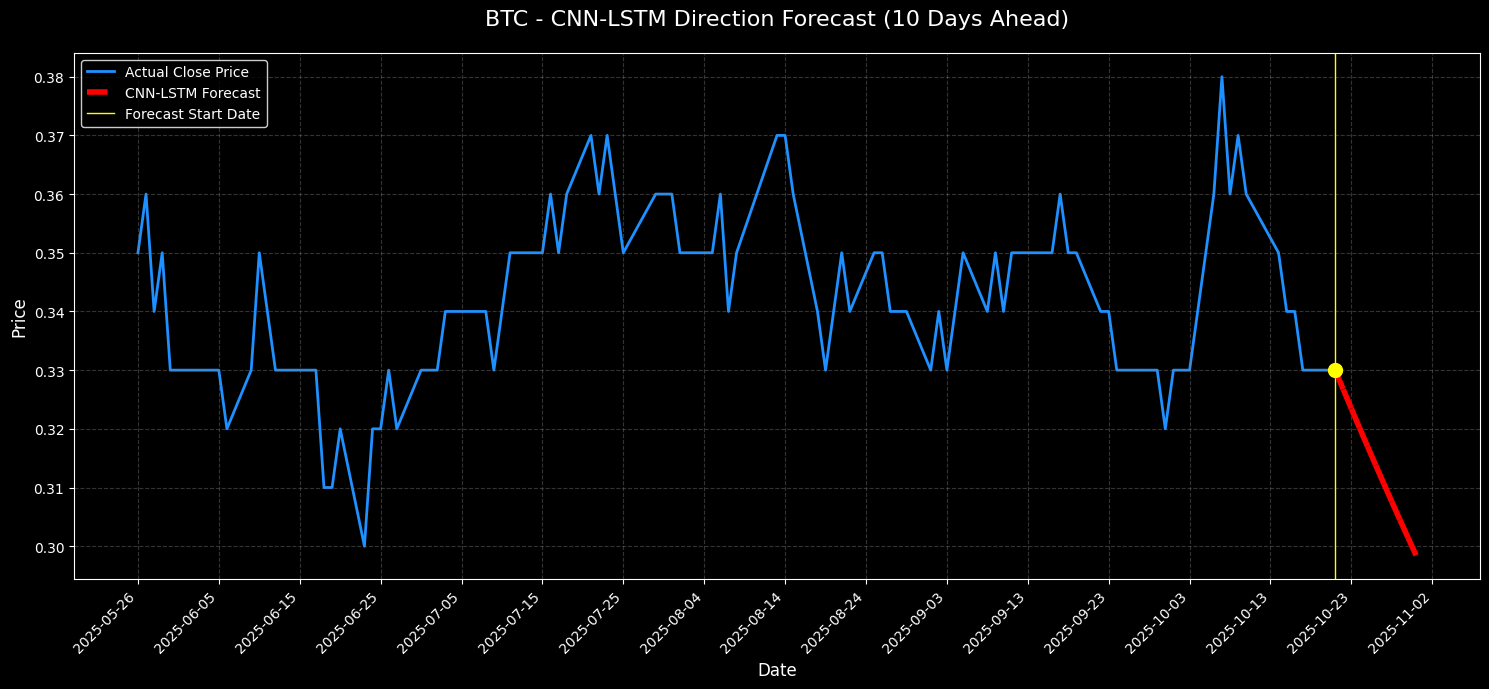


--- 📉 แสดงกราฟ Classic Pattern (H&S/IH&S) ---
พบรูปแบบ H&S/IH&S ทั้งหมด: 0 จุด
ไม่พบรูปแบบ H&S/IH&S ที่จะแสดงบนกราฟ


In [79]:
if __name__ == '__main__':
    try:
        # --- Config ---
        symbol = "BTC"
        DATA_LIMIT = 100  # ใช้ข้อมูลเยอะขึ้นสำหรับการฝึก LSTM
        SEQUENCE_LENGTH = 30
        FUTURE_DAYS = 1   # ทำนายทิศทางของวันถัดไป (1 วัน)
        EPOCHS = 5
        
        # 1. รัน Pipeline (ฝึกโมเดลทำนายทิศทาง 0/1)
        print("\n--- 🧠 เริ่มฝึกโมเดล CNN-LSTM ---")
        model, df_original, scaler, X_val, y_val = train_pipeline(
            symbol=symbol, 
            cass_limit=DATA_LIMIT, 
            seq_len=SEQUENCE_LENGTH, 
            epochs=EPOCHS,
            future_days=FUTURE_DAYS
        ) 

        # 2. ประเมินผล (แสดงความแม่นยำในการทำนายทิศทาง)
        y_pred = model.predict(X_val, verbose=0)
        y_pred_cls = np.argmax(y_pred, axis=1)
        print("\n--- Model Evaluation (Validation Set) ---")
        print(classification_report(y_val, y_pred_cls, target_names=['0: Down/Flat', '1: Up'], zero_division=0))

        # 3. แสดงกราฟ Price Direction Forecast (CNN-LSTM)
        print("\n--- 📈 แสดงกราฟ Price Direction Forecast (CNN-LSTM) ---")
        plot_future_direction_forecast(
            df_original, 
            model, 
            scaler, 
            seq_len=SEQUENCE_LENGTH, 
            symbol=symbol, 
            forecast_steps=10
        )
        
        # 4. ตรวจจับและแสดงผล Classic Pattern (H&S/IH&S)
        print("\n--- 📉 แสดงกราฟ Classic Pattern (H&S/IH&S) ---")
        classic_patterns = detect_head_shoulders(df_original, distance=5, tolerance=0.03)
        print(f"พบรูปแบบ H&S/IH&S ทั้งหมด: {len(classic_patterns)} จุด")
        
        # เรียกใช้ฟังก์ชันที่แก้ไขแล้ว
        plot_classic_pattern(df_original, classic_patterns, symbol=symbol)
        
    except ConnectionRefusedError as e:
        print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
        print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
    except ValueError as e:
        print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")